# Determining Water Potability

## Introduction

Water potability is critical for supporting populations, various industries and agricultural activities that rely on clean water for survival. Clean and drinkable water can be determined by careful analysis of certain characteristics of a sample. Using classification we hope to train a data set to be able to classify water as safe or not based on its characteristics. The question we will be asking is: Does the water sample meet potability standards considering its various levels and characteristics?
The data set we will be using is ‘Water Quality and Potability’. Each observation has a pH value, total solids dissolved, chloramines count, sulfate count, conductivity, organic carbon level, trihalomethanes, turbidity and potability. With these values we hope to provide accurate results on potability. 
This data set is from Kaggle, a cite that provides a multitude of data sets open to the public. This data set was originally sourced from GitHub, the URL to this specific data set on GitHub is https://github.com/MainakRepositor/Datasets/blob/master/water_potability.csv. 


## Reading in the Data

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
options(repr.matrix.max.rows = 6)
set.seed(1234)

#reading the data set from the web 
water <- read_csv("https://raw.githubusercontent.com/nori-2004/data-science-group-project/main/water_potability.csv")


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Cleaning and Wrangling

In [2]:

#changing the potable variable to a factor datatype
water<- water |> 
    mutate(Potability = as_factor(Potability))

#removing missing values 
initial_rows <- nrow(water)

water <- na.omit(water)

final_rows <- nrow(water)

removed_rows <- initial_rows - final_rows

#cleaning the data by selecting the columns we want to use
water_selected <- select(water, - Conductivity)

water_selected

ph,Hardness,Solids,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
8.316766,214.3734,22018.42,8.059332,356.8861,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,8.399735,54.91786,2.559708,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11.491011,94.81255,37188.83,9.263166,258.9306,16.17276,41.55850,4.369264,1
6.069616,186.65904,26138.78,7.747547,345.7003,12.06762,60.41992,3.669712,1
4.668102,193.68174,47580.99,7.166639,359.9486,13.89442,66.68769,4.435821,1


In [3]:
#splitting the data into testing and training sets
water_split <- initial_split(water_selected, prop = 0.75)
water_train <- training(water_split)   
water_test <- testing(water_split)

## Summary Tables

In [4]:
#counting the number of observations that are potable and not potable

water_count<-water_train|>
    group_by(Potability)|>
    summarize(count=n())
water_count

print("number of rows removed were")
removed_rows

# Count available data for each column
available_data_counts <- map_df(water_train, ~sum(!(is.nan(.x)|is.na(.x))))
print("Available data counts (non-available data was removed)")
available_data_counts

# portable: not or able
portability_table <- table(water_train$Potability)
print("Potability table: 0 for not and 1 for able")
portability_table

# Calculate the ratio of portable vs non portable data
portability_ratio <- portability_table[2] / portability_table[1]
print("Probability ratio - the probability of the water sample to be not potable")
portability_ratio

# Select just the predictors
water_train_predictors = select(water_train, -Potability)

# Means of the predictors
predictor_means <- colMeans(water_train_predictors, na.rm = TRUE)
print("Means of the predictors")
predictor_means

Potability,count
<fct>,<int>
0,892
1,616


[1] "number of rows removed were"


[1] 1265

[1] "Available data counts (non-available data was removed)"


ph,Hardness,Solids,Chloramines,Sulfate,Organic_carbon,Trihalomethanes,Turbidity,Potability
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1508,1508,1508,1508,1508,1508,1508,1508,1508


[1] "Potability table: 0 for not and 1 for able"



  0   1 
892 616 

[1] "Probability ratio - the probability of the water sample to be not potable"


1 
0.690583

[1] "Means of the predictors"


ph        Hardness          Solids     Chloramines         Sulfate 
       7.105768      195.732508    21855.236205        7.129208      334.074007 
 Organic_carbon Trihalomethanes       Turbidity 
      14.360075       66.068931        3.962126

## Graphs 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


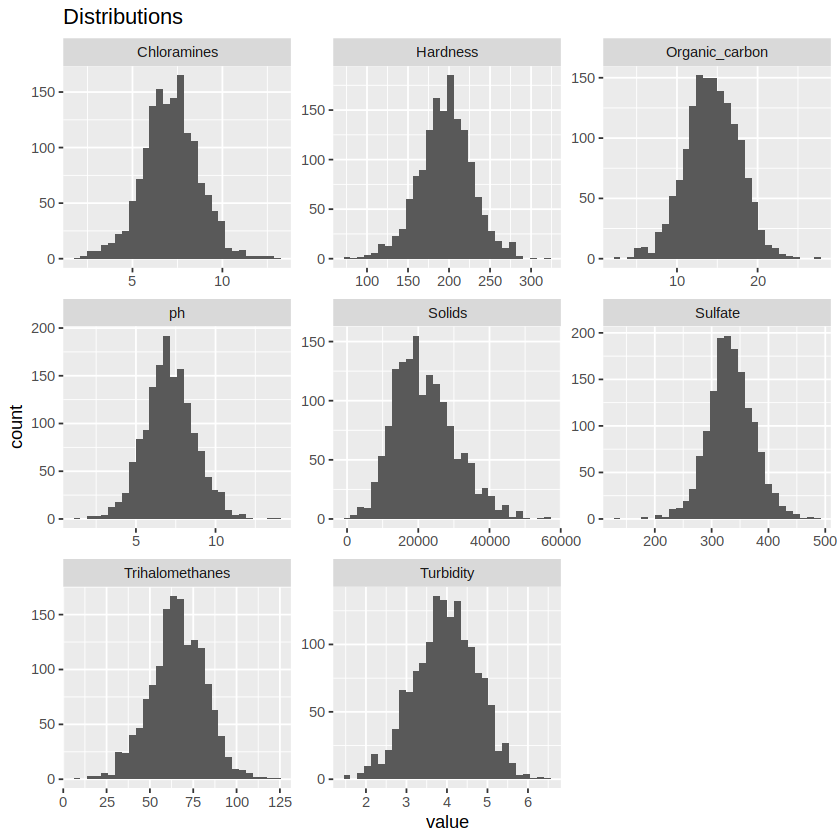

In [5]:
# Exploratory Graphs for the predictors

# Distributions
water_train_predictors |>
    gather(variable, value) |>
    ggplot(aes(x = value)) +
    geom_histogram() +
    facet_wrap(~ variable, scales = "free") +
    ggtitle("Distributions")


## Methodology

The problem that we have selected is a classification problem, i.e. classifying a sample of water into potable or non-potable. We will be using the K nearest neighbour classification do to so. Out of the 8 variables in our dataset, we will be using all of them as predictors besides conductivity. First, we shall prepare the data by tidying it and splitting it into training an testing sets. Then we will use cross-validation to pick the best “k” value for our dataset and then train the model using the training set, and then apply it to the testing set. This will ensure that we produce a classifier with the highest accuracy possible. Though, it would be ideal to have high precision and high recall, we shall be aiming to have a high recall with not-potable being the “positive” class. 


To create the visualization which answers our main questions we create an artificial data set using 10,000 random samples. These random samples are evenly distributed from zero to the maximum values in the original data set. This method allows us to identify which values of each parameter are more likely to be found in potable water using our K nearest classification model. The visualization overlays potable and non-potable distributions. The intersection points of the potable and non-potable bell curves indicates a transition from being more likely to be classified as one verses the other. 

## Performing the analysis 

**which $k$ should we use?**

Below we we will be doing the following: 
- Creating a recipe that uses all predictors (besides conductivity).
- Creating a model specification with tuning on the number of neighbours.
- Performing a 10-fold cross-validation 
- Plotting a graph of $k$ vs the accuracy to determining the $k$ with the highest accuracy for our data set. 

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


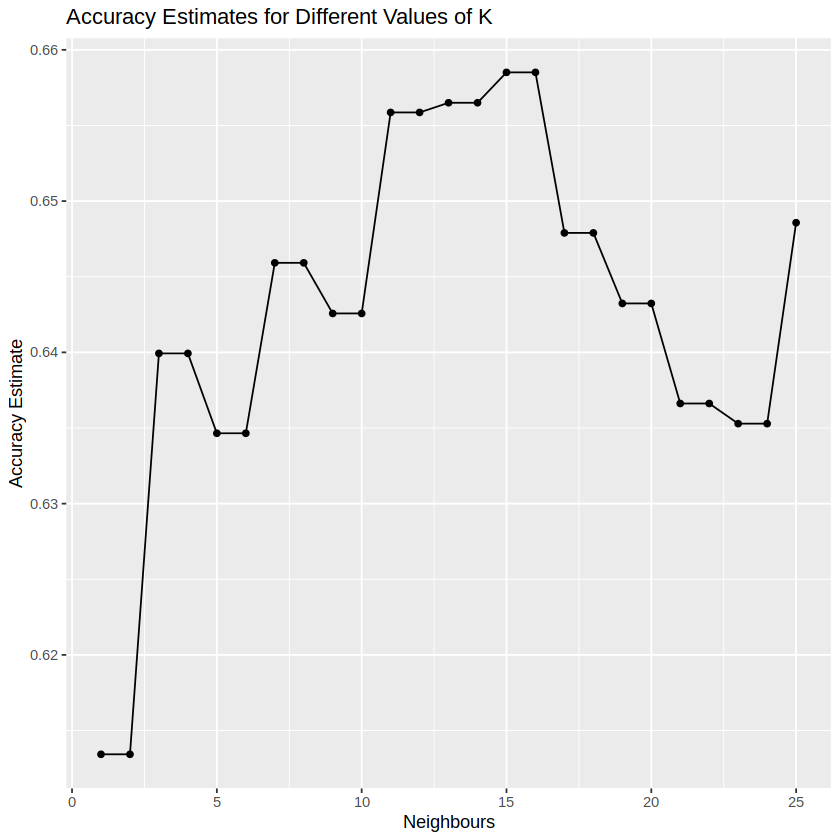

In [6]:
## creating the recipe and scaling and centering all predictors 
water_recipe <- recipe(Potability ~ . , data = water_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

# 10 fold cross validation
k_vfold <- vfold_cv(water_train, v = 10, strata = Potability)

knn_workflow <- workflow() |>
    add_recipe(water_recipe)|>
    add_model(knn_spec)

knn_workflow

# testing k values from 1 to 25  
k_vals <- tibble(neighbors = seq(from = 1, to = 25))

knn_results <- knn_workflow |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

# plotting to check for the best value of K 
cross_validation_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbours", y = "Accuracy Estimate")+
    ggtitle("Accuracy Estimates for Different Values of K")

cross_validation_plot

## Building Our Model
To build the model, we will be doing the following 
- building model specification with the best value of $k$
- reporting the accuracy of predictions 

In [7]:
best_k = 15
water_spec <- nearest_neighbor(weight_func= "rectangular", neighbors = best_k)|>
    set_engine("kknn")|>
    set_mode("classification")

water_fit <- workflow()|>
    add_recipe(water_recipe)|>
    add_model(water_spec)|>
    fit(data = water_train) 

water_predictions <- predict(water_fit, water_test)|>
                     bind_cols(water_test)


water_metrics <- water_predictions |>
    metrics(truth = Potability, estimate = .pred_class) |>
    filter(.metric == "accuracy")|>
    select(.estimate) |>
    pull()

water_metrics

[1] 0.6799205

## Ploting the model
To plot the model, we will be doing the following
* Generating evenly distributed random samples
* Using our model to predict the portability of the samples
* Using the predictions for the random samples, we plot the distributions of the predictors (water parameters) for portable water overlayed with the distributions of the predictors for non portable water

To read these plots consider a particular water parameter such as ph. Read the ph values where the blue line is higher than the red. At these ph values the sample is more likely to be catigorized as potable than non-potable by our model. The potability of water depends on all of the water parameters so ensuring a safe ph does not mean the sample will be potable without considering the other parameters as well. The grey area indicate overlap between the distributions.

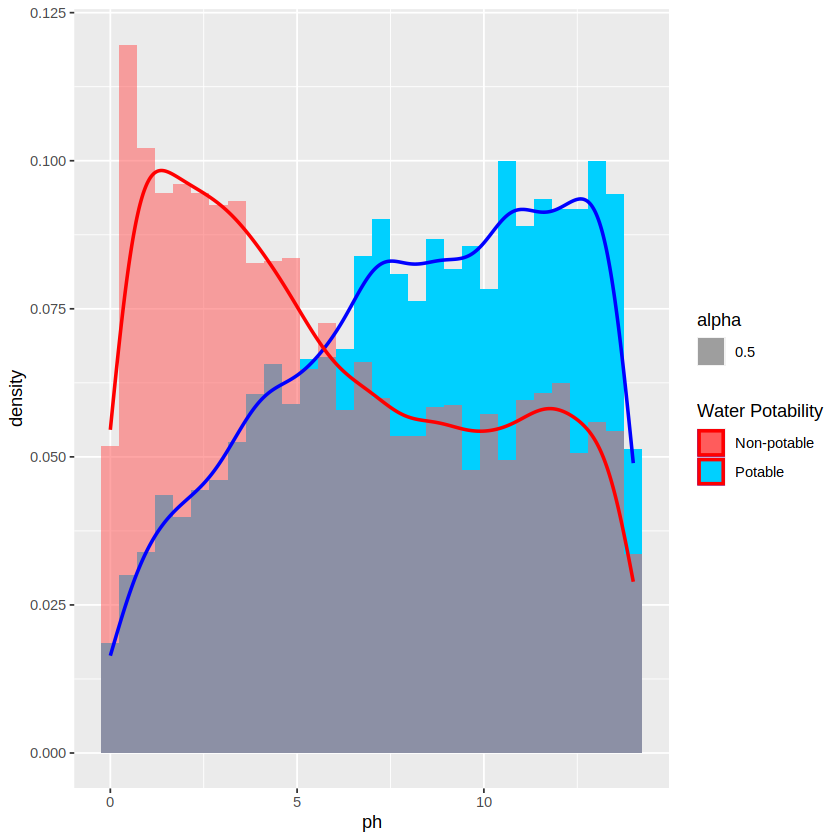

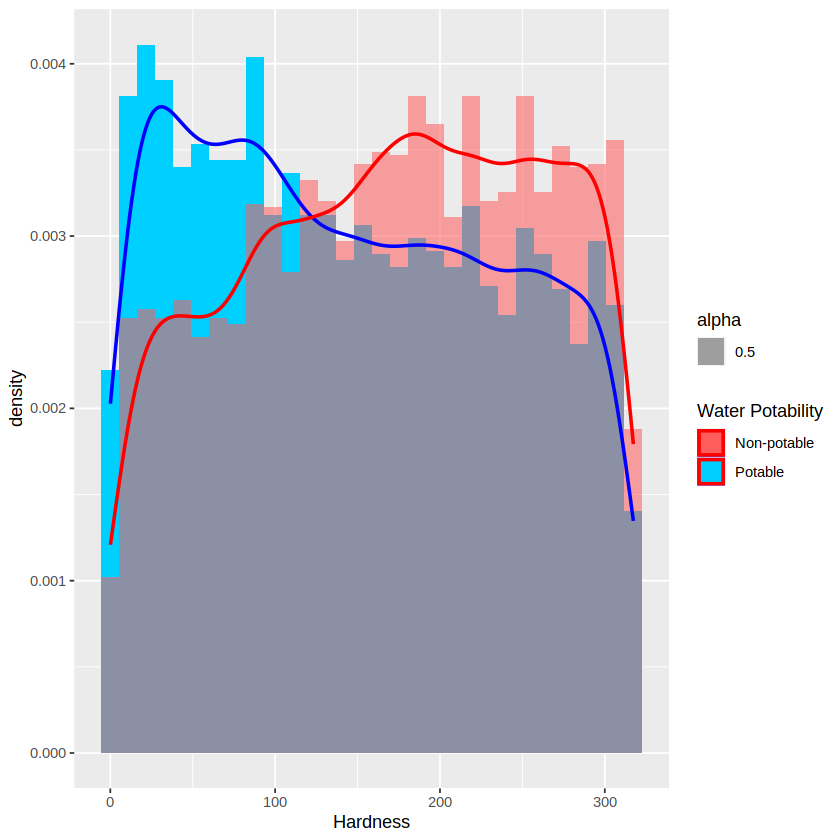

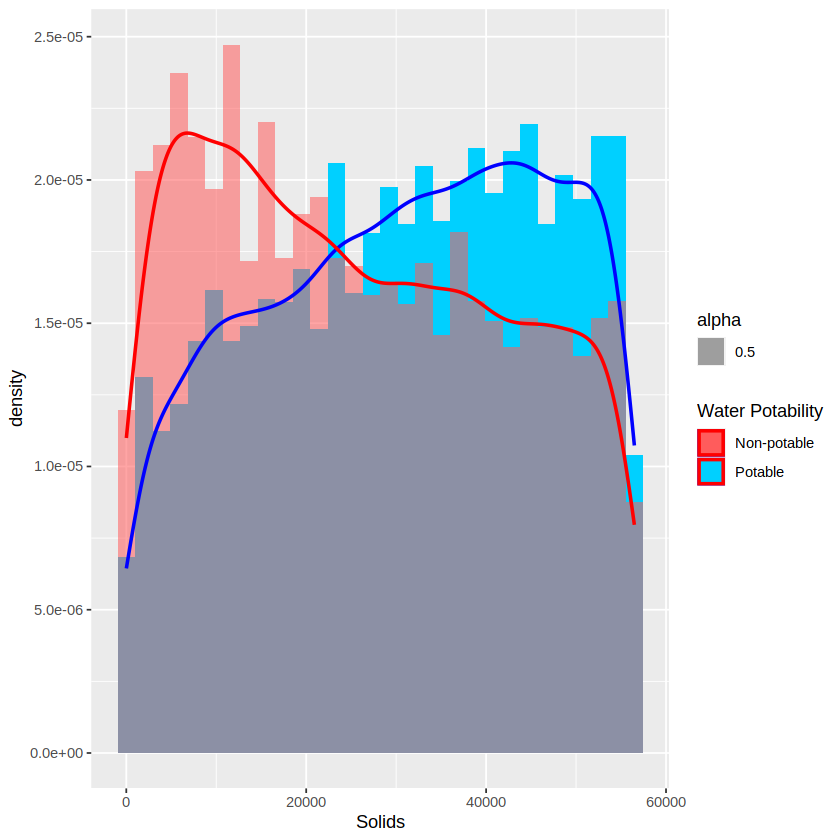

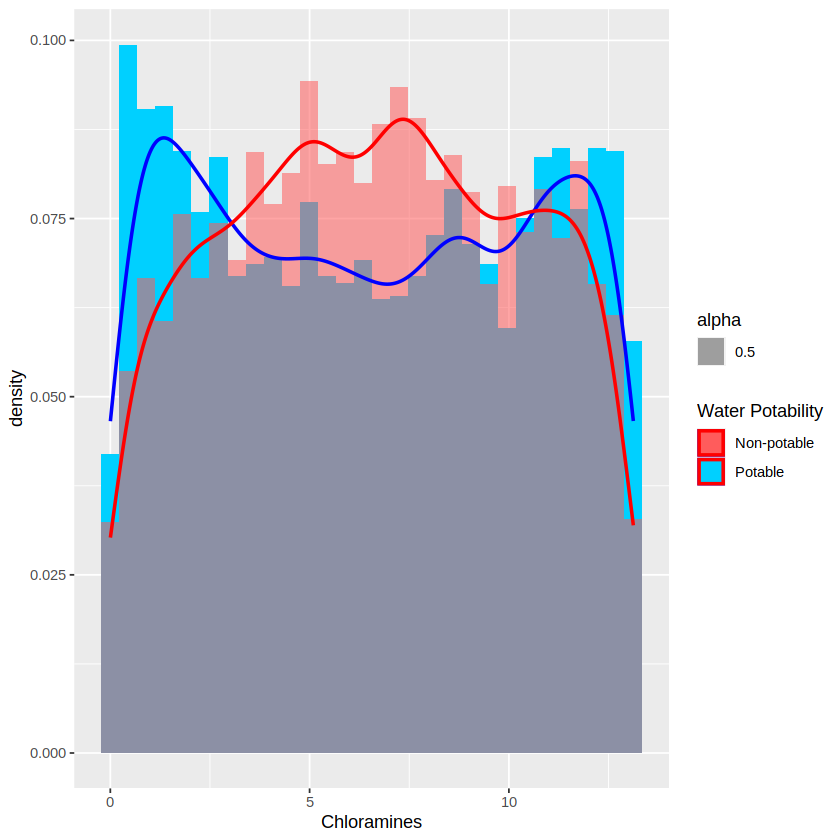

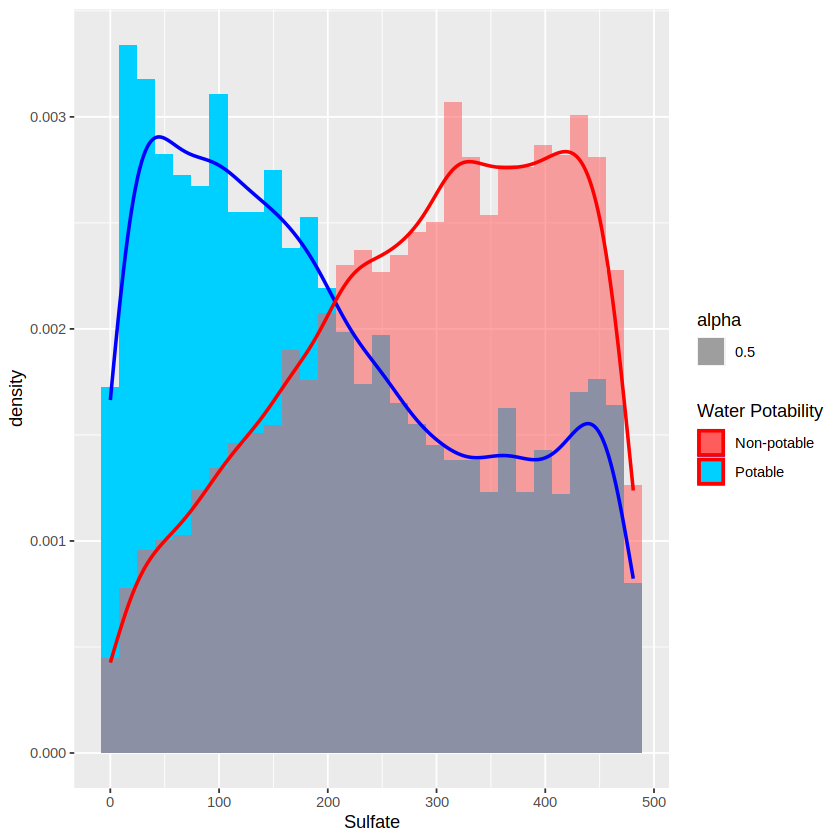

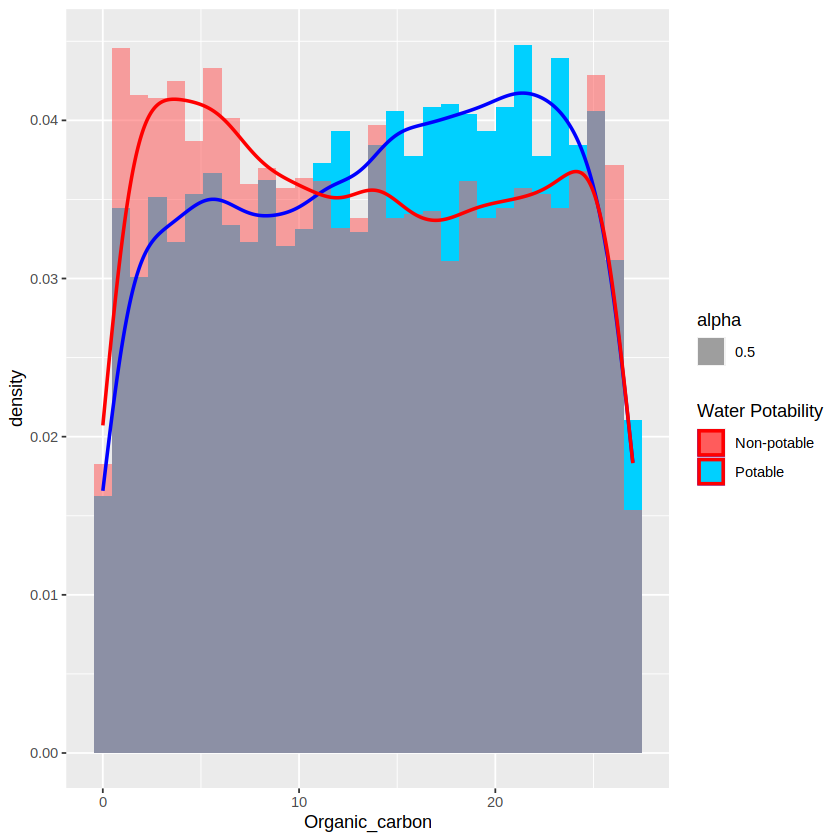

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


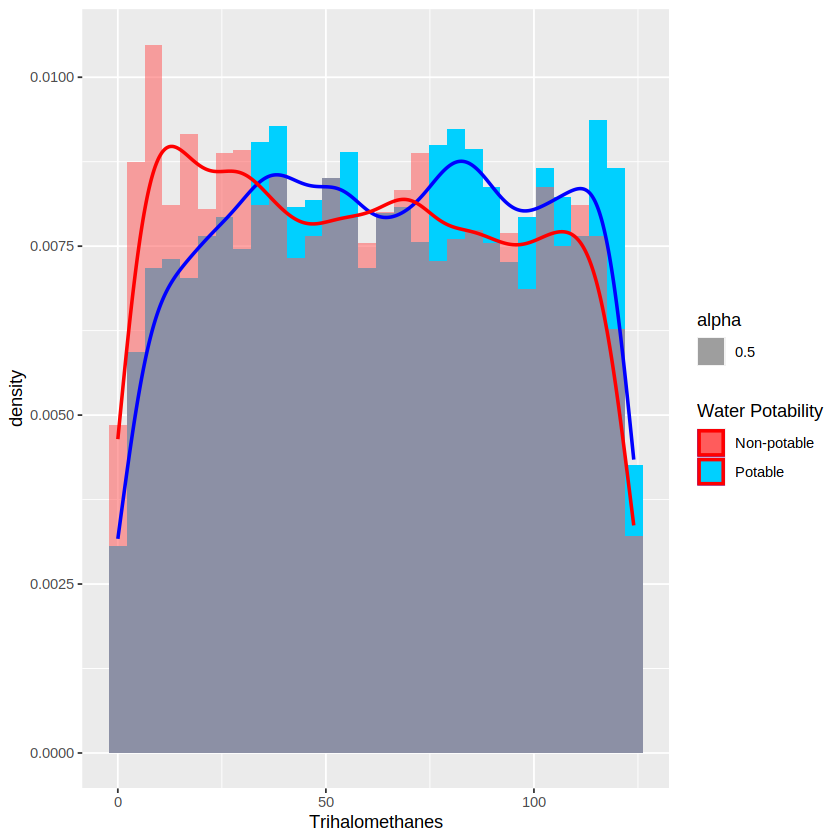

[1] "Confusion Matrix"


          Truth
Prediction   0   1
         0 267 120
         1  41  75

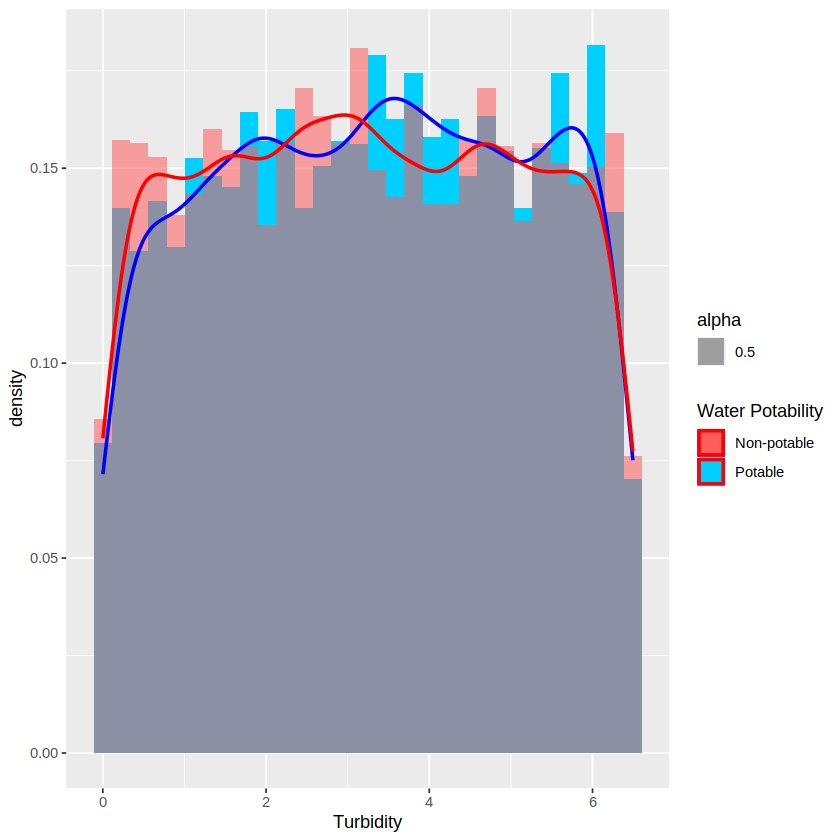

In [8]:
# Select just the predictors
water_predictors <- select(water_selected, !Potability)

# Generate an even data set of values between min and max for each predictors
random_samples_between_min_max <- function(column){

#     Lower samples for speed
    random_samples = 10000
    expansion_coeff = 0

    min_val <- column |>
        min()

    max_val <- column |>
        max()

    # Expand the size of the data by a portion of the width
    width <- max_val-min_val
    expansion <- width * expansion_coeff
    
    min_val <- 0 #max(min_val-expansion, 0)
    max_val <- max_val+expansion
    
    values <- runif(random_samples, min_val, max_val)

    return(values)
}


rand_samples <- map_df(water_predictors, random_samples_between_min_max)

# From the random sample of predictors predict which are portable
rand_samples_predictions <- predict(water_fit, rand_samples)|>
                     bind_cols(rand_samples)

# Separating potable from non potable predictions
rand_samples_predictions_potable <- rand_samples_predictions |>
    filter(.pred_class == 1)

rand_samples_predictions_non_potable <- rand_samples_predictions |>
    filter(.pred_class == 0)


# Function to plot a comparison betwen potable and non potable predictors
potable_distribution_comparison_plot <- function(column){
    num_bins <- 30
    
    plot <- ggplot() +
#     Plot distributions
    geom_histogram(data = rand_samples_predictions_potable, 
        mapping = aes(x = .data[[column]], y = after_stat(density), fill = 'Potable'),
        bins = num_bins) +
    geom_histogram(data = rand_samples_predictions_non_potable, 
        mapping = aes(x = .data[[column]], y = after_stat(density), fill = 'Non-potable', alpha  = 0.5),
        bins = num_bins) +
    
#     Plot bell curves
    geom_density(data = rand_samples_predictions_potable, 
        mapping = aes(x = .data[[column]], y = after_stat(density), color = 'Potable'),
        linetype = 'solid', linewidth = 1, color = 'blue') +
    geom_density(data = rand_samples_predictions_non_potable, 
        mapping = aes(x = .data[[column]], y = after_stat(density), color = 'Non-potable'),
        linetype = 'solid', linewidth = 1, color = 'red') +
    
    labs(fill = "Water Potability", color = "Water Potability") +
    scale_fill_manual(values = c("Potable" = '#00d0ff', "Non-potable" = "#ff5c5c")) +
    scale_color_manual(values = c("Potable" = "blue", "Non-potable" = "red"))

    return(plot)
}



#  Plot the comparison
column_names <- colnames(rand_samples)
plots_comparison <- column_names|>
    map(potable_distribution_comparison_plot)

plots_comparison



print("Confusion Matrix")
confusion_matrix <- water_predictions |>
             conf_mat(truth = Potability, estimate = .pred_class)
confusion_matrix

## Outcomes and Significance 

Farren's part: 
Our expectations in accuracy and predictor outcomes surprised and met our hypotheses. We expected our model to be more accurate in classifying. We found the model to have an accuracy of ~67% which is not a reliant number in the field. This model unfortunately could not be dependable when used on a mass scale. When researching this we found a report on a similar dataset classifying potability with the same predictors. In the report the data scientists performed the classification using two different classification methods. One of them performed highly, around 97% and one performed more poorly around 62% similar to our KNN classification. These findings show the potential for water sample classification to be useful and possible, though KNN is not the classification system that can provide a reliable accuracy. In being able to predict the classification of water samples it is possible for quicker and reliable water classification. In using classification we can determine locations in which water samples are potable or not ensuring safety for populations relying on that water. This may improve overall public health help highlight communities that are at risk to unsafe water.  
In terms of predictors we were surprised at some of our findings. The predictor ‘solids’ did not meet our initial expectations. Firstly the graphs of solids show the more solids a sample has the more likely it is to be potable. This surprised us because commonly clean drinkable water has less solids. All the rest of the predictors met our intuition, for example Sulfate is safe to drink in water with lower levels. This matched the sulfate plot: as the sulfate level rises the lower the potability becomes. 
These findings can lead to a plethora of questions to explore. Why does a higher solid count corelate potability? Such questions to do with the relationship between predictors and classification can provide a more in depth understanding of safe levels of each predictor. On a larger scale we can explore how classification can optimize how to treat wastewater. In utilizing classification to determine drinking water safety we can aid in the fight against water scarcity and help improve public health. 
